In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import shap

import xgboost
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


PATH_PROJECT = "/home/yoshraf/projects/mestrado/"

X_train = pd.read_parquet(f"{PATH_PROJECT}data/counting_trips/X_train_night.parquet")
X_test = pd.read_parquet(f"{PATH_PROJECT}data/counting_trips/X_test_night.parquet")
y_train = pd.read_parquet(f"{PATH_PROJECT}data/counting_trips/y_train_night.parquet")
y_test = pd.read_parquet(f"{PATH_PROJECT}data/counting_trips/y_test_night.parquet")

In [2]:
shap.initjs()

In [3]:
def valid_model(y_train, y_test, y_pred_train, y_pred_test):
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)
    print("----Train---")
    print(f"MAE: {mae_train:.2f}")
    print(f"MSE: {mse_train:.2f}")
    print(f"R2: {r2_train:.2f}")
    print("---- Test ---")
    print(f"MAE: {mae_test:.2f}")
    print(f"MSE: {mse_test:.2f}")
    print(f"R2: {r2_test:.2f}")
    return None

def lr_modeling(X_train, X_test, y_train, y_test):
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    y_pred_train = reg.predict(X_train)
    y_pred_test = reg.predict(X_test)
    valid_model(y_train, y_test, y_pred_train, y_pred_test)
    return reg

def rf_modeling(X_train, X_test, y_train, y_test, params):
    reg = RandomForestRegressor(**params)
    reg.fit(X_train, y_train)
    y_pred_train = reg.predict(X_train)
    y_pred_test = reg.predict(X_test)
    feats = {}
    for feature, importance in zip(X_train.columns, reg.feature_importances_):
        feats[feature] = importance * 100
    df_imp = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'}).sort_values("Importance", ascending=False)
    print("Main Features:")
    print(df_imp.head(10))
    valid_model(y_train, y_test, y_pred_train, y_pred_test)
    return reg

def xgb_modeling(X_train, X_test, y_train, y_test, params):
    model_xgb = xgboost.XGBRegressor(**params)
    model_xgb.fit(X_train, y_train)
    y_pred_train = model_xgb.predict(X_train)
    y_pred_test = model_xgb.predict(X_test)
    valid_model(y_train, y_test, y_pred_train, y_pred_test)
    return model_xgb


In [4]:
lr_modeling(X_train, X_test, y_train, y_test)

----Train---
MAE: 0.19
MSE: 0.10
R2: 0.12
---- Test ---
MAE: 0.18
MSE: 0.10
R2: 0.10


LinearRegression()

In [5]:
rf_params = {}
reg = rf_modeling(X_train, X_test, y_train, y_test, {})

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Main Features:
                              Importance
loc_domicilio_count_ilum_std   11.213929
Idade                          10.725808
per Renda familiar mensal       8.807953
loc_domicilio_dist_trem         8.141271
loc_domicilio_dist_term         7.783974
loc_domicilio_dist_ciclo        7.531763
loc_domicilio_dist_metro        7.349411
loc_domicilio_count_parada      6.018705
loc_domicilio_ACC_TI_A_E_60M    5.157357
loc_domicilio_ACC_TI_A_L_TP_    4.557733
----Train---
MAE: 0.06
MSE: 0.01
R2: 0.88
---- Test ---
MAE: 0.17
MSE: 0.10
R2: 0.15


In [6]:
rf_params = {"n_estimators": 100, "max_depth": 12, "random_state": 0, "min_samples_leaf": 30, "max_features": "auto", "max_samples": .8, "n_jobs": -1}
reg = rf_modeling(X_train, X_test, y_train, y_test, rf_params)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Main Features:
                                            Importance
loc_domicilio_count_ilum_std                 20.007407
Idade                                        18.210612
Estuda atualmente?__outros_                  14.938123
Condição de atividade_Tem Trabalho Regular    7.817183
per Renda familiar mensal                     4.872643
loc_domicilio_count_parada                    4.632622
loc_domicilio_dist_metro                      4.010748
loc_domicilio_dist_trem                       3.862150
loc_domicilio_dist_term                       3.484578
loc_domicilio_ACC_TI_A_L_TP_                  3.332682
----Train---
MAE: 0.16
MSE: 0.09
R2: 0.26
---- Test ---
MAE: 0.16
MSE: 0.09
R2: 0.16


In [9]:
params_xgb = {"max_depth": 3, "subsample": 0.8, "learning_rate": 0.1, "n_estimators": 1000,  "scale_pos_weight": 1, "seed": 42}
reg_xgb = xgb_modeling(X_train, X_test, y_train["Total Viagens Noturnas"].values, y_test["Total Viagens Noturnas"].values, params_xgb)

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


----Train---
MAE: 0.15
MSE: 0.08
R2: 0.36
---- Test ---
MAE: 0.17
MSE: 0.09
R2: 0.16


In [10]:
explainer = shap.TreeExplainer(reg_xgb)
shap_values = explainer(X_test.sample(5000))

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [6]:
explainer = shap.Explainer(reg)
shap_values = explainer(X_test)

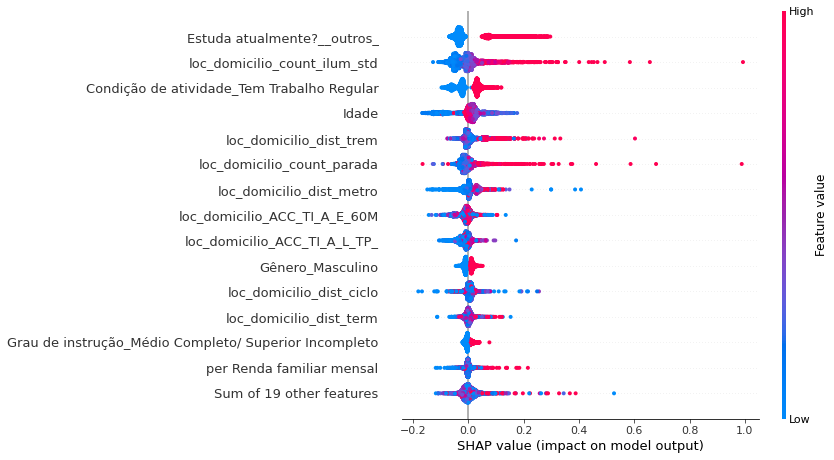

In [11]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=15)

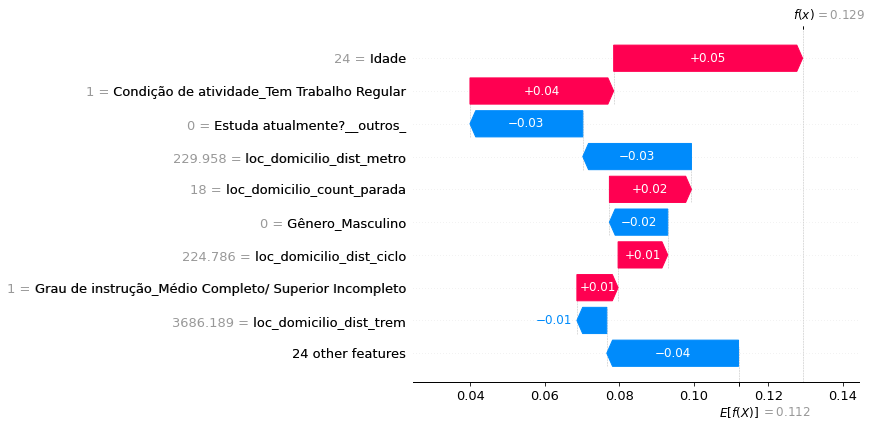

In [12]:
shap.waterfall_plot(shap_values[0])

In [13]:
shap_values.feature_names

['Idade',
 'loc_domicilio_count_parada',
 'loc_domicilio_count_ilum_led',
 'loc_domicilio_count_ilum_std',
 'loc_domicilio_dist_metro',
 'loc_domicilio_dist_trem',
 'loc_domicilio_dist_term',
 'loc_domicilio_dist_ciclo',
 'loc_domicilio_ACC_TI_A_E_60M',
 'loc_domicilio_ACC_TI_A_L_TP_',
 'per Quantidade de automóveis',
 'per Quantidade de motocicletas',
 'per Quantidade de bicicletas',
 'per Renda familiar mensal',
 'Situação familiar_Conjugê/ companheiro(a)',
 'Situação familiar_Filho(a)/ enteado(a)',
 'Situação familiar_Pessoa responsável',
 'Situação familiar__outros_',
 'Gênero_Masculino',
 'Estuda atualmente?__outros_',
 'Grau de instrução_Fundamental I Completo/ Fundamental II Incompleto',
 'Grau de instrução_Fundamental II Completo/ Médio Incompleto',
 'Grau de instrução_Médio Completo/ Superior Incompleto',
 'Grau de instrução_Não Alfabetizado/ Fundamental I Incompleto',
 'Grau de instrução_Superior Completo',
 'Condição de atividade_Aposentado/ Pensionista',
 'Condição de ativi

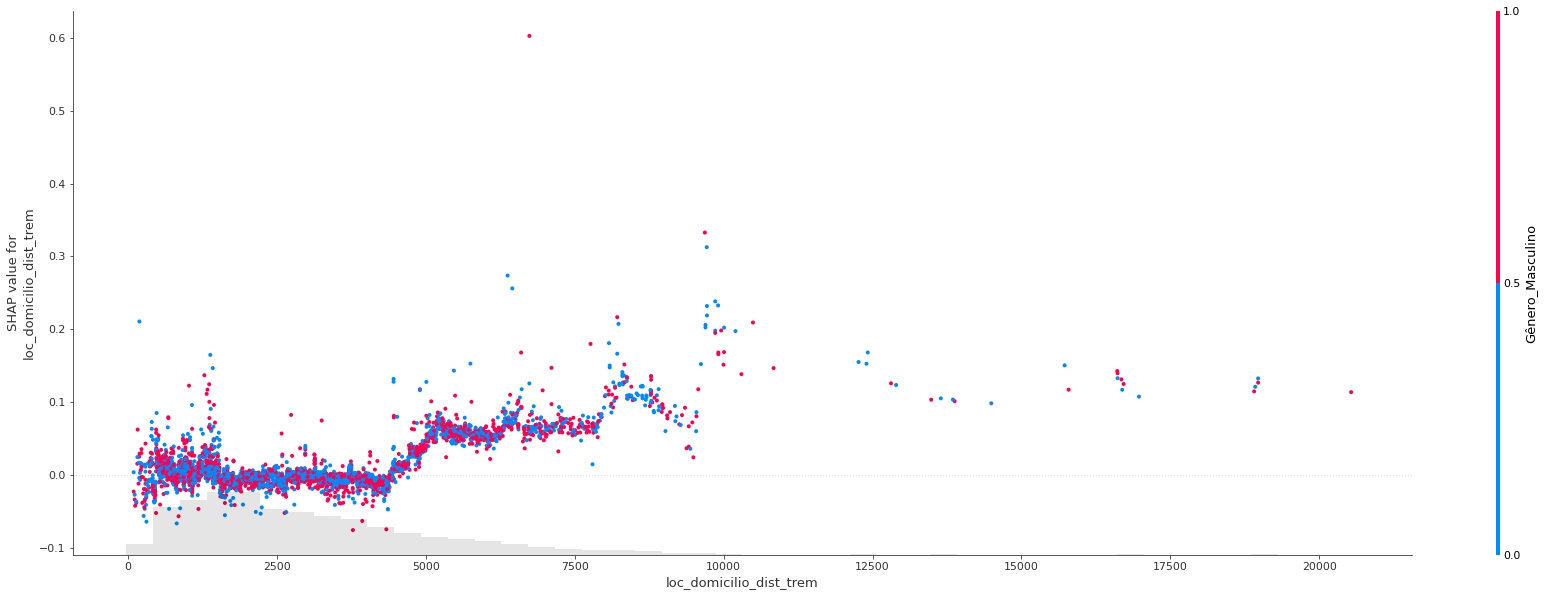

In [21]:
fig, ax = plt.subplots(1, figsize=(30,10))
shap.plots.scatter(shap_values[:,"loc_domicilio_dist_trem"], shap_values[:,"Gênero_Masculino"], ax=ax)

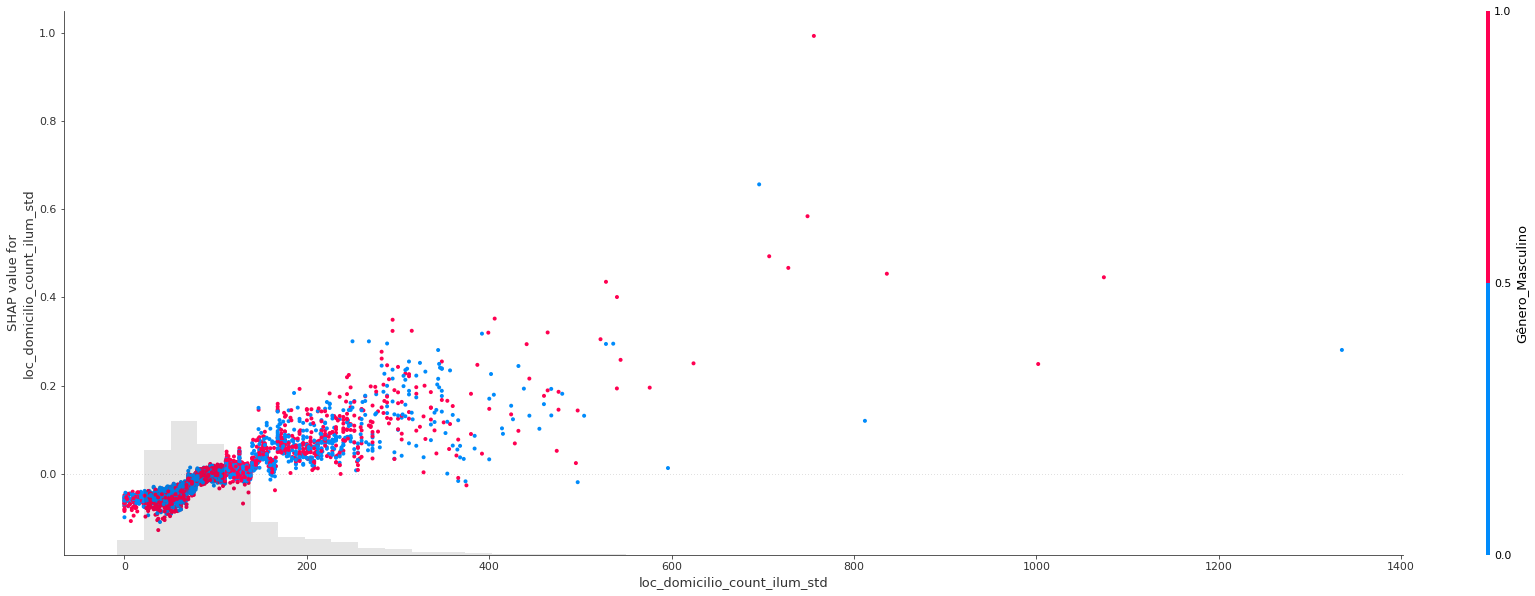

In [17]:
fig, ax = plt.subplots(1, figsize=(30,10))
shap.plots.scatter(shap_values[:,"loc_domicilio_count_ilum_std"], shap_values[:,"Gênero_Masculino"], ax=ax)

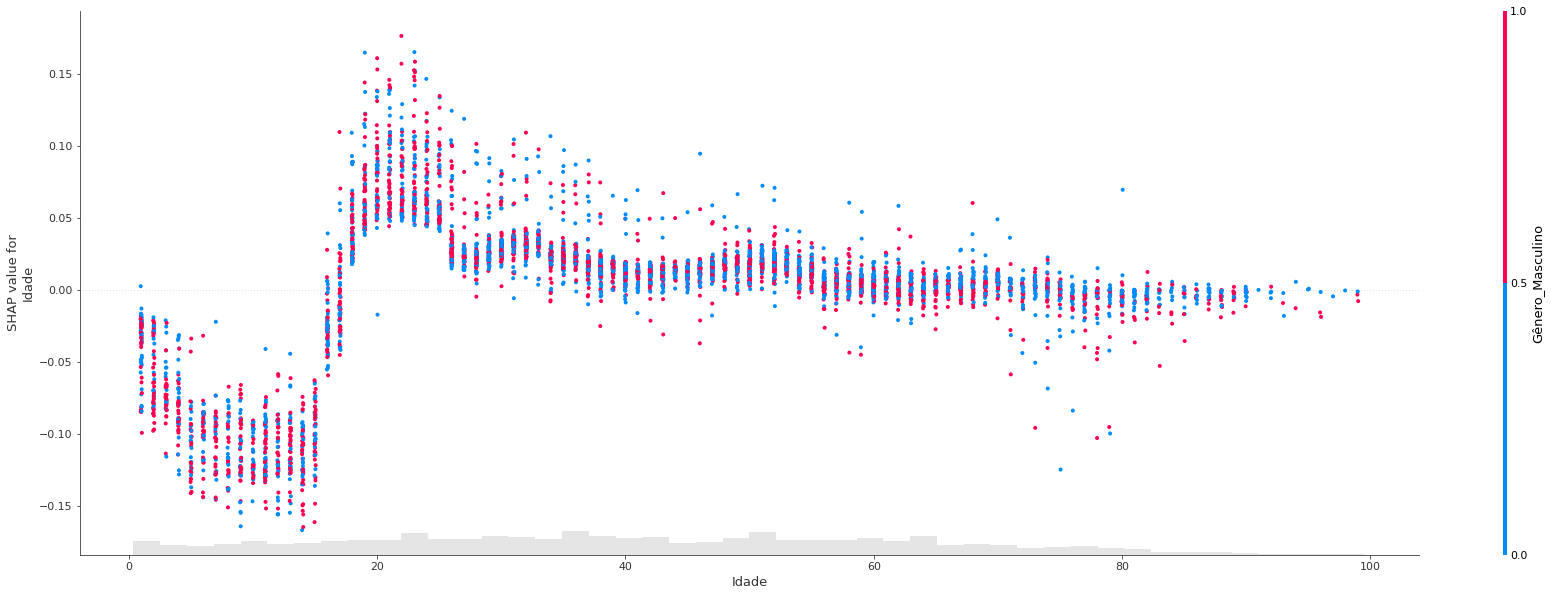

In [19]:
fig, ax = plt.subplots(1, figsize=(30,10))
shap.plots.scatter(shap_values[:,"Idade"], shap_values[:,"Gênero_Masculino"], ax=ax)

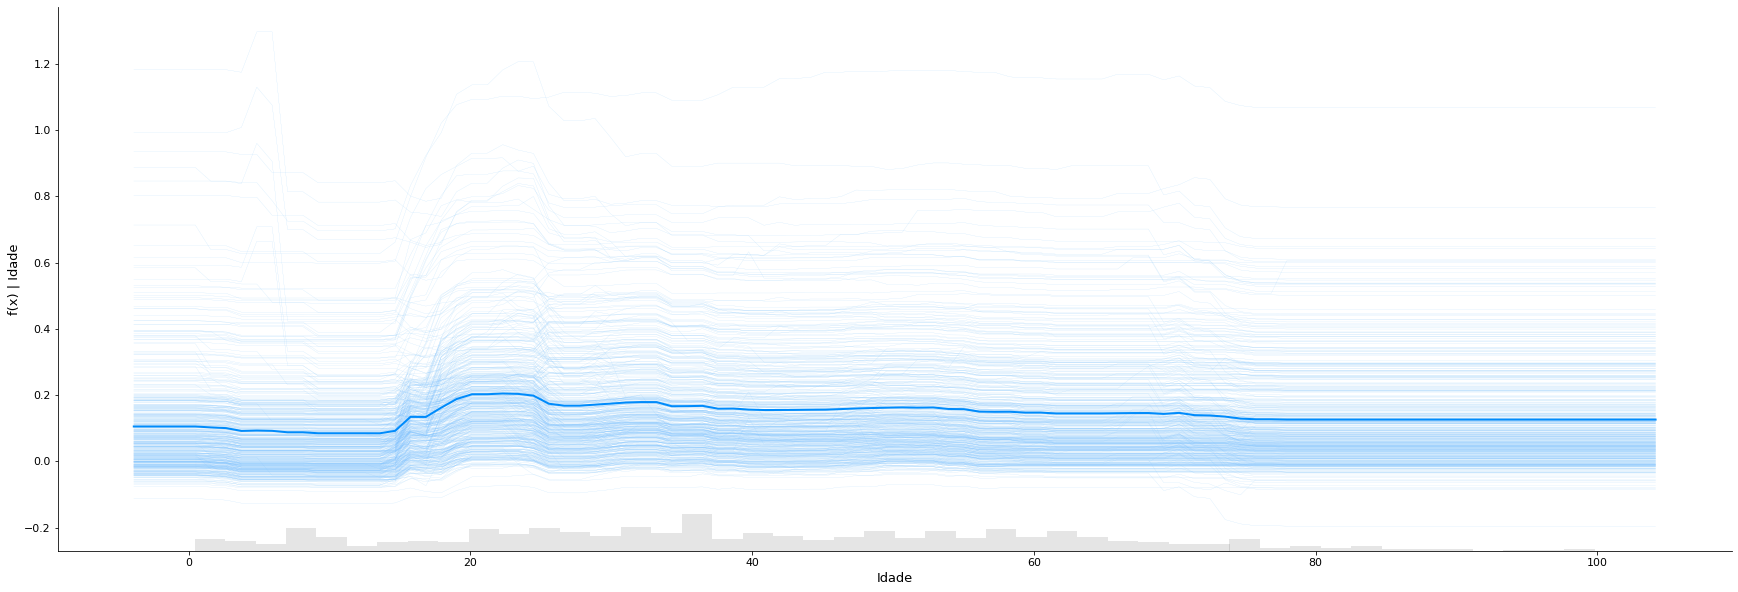

In [146]:
fig, ax = plt.subplots(1, figsize=(30,10))
shap.partial_dependence_plot("Idade", reg_xgb.predict, X_train.sample(500), ax=ax)

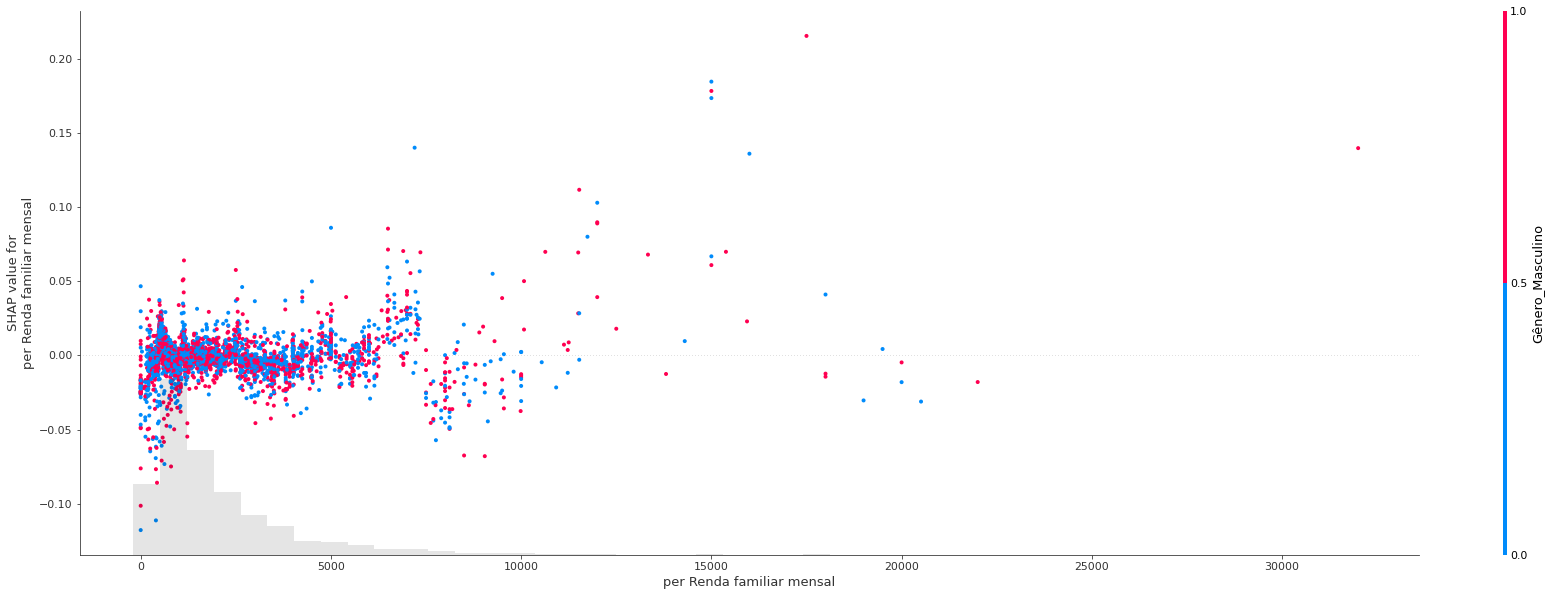

In [20]:
fig, ax = plt.subplots(1, figsize=(30,10))
shap.plots.scatter(shap_values[:,"per Renda familiar mensal"], shap_values[:,"Gênero_Masculino"], ax=ax)

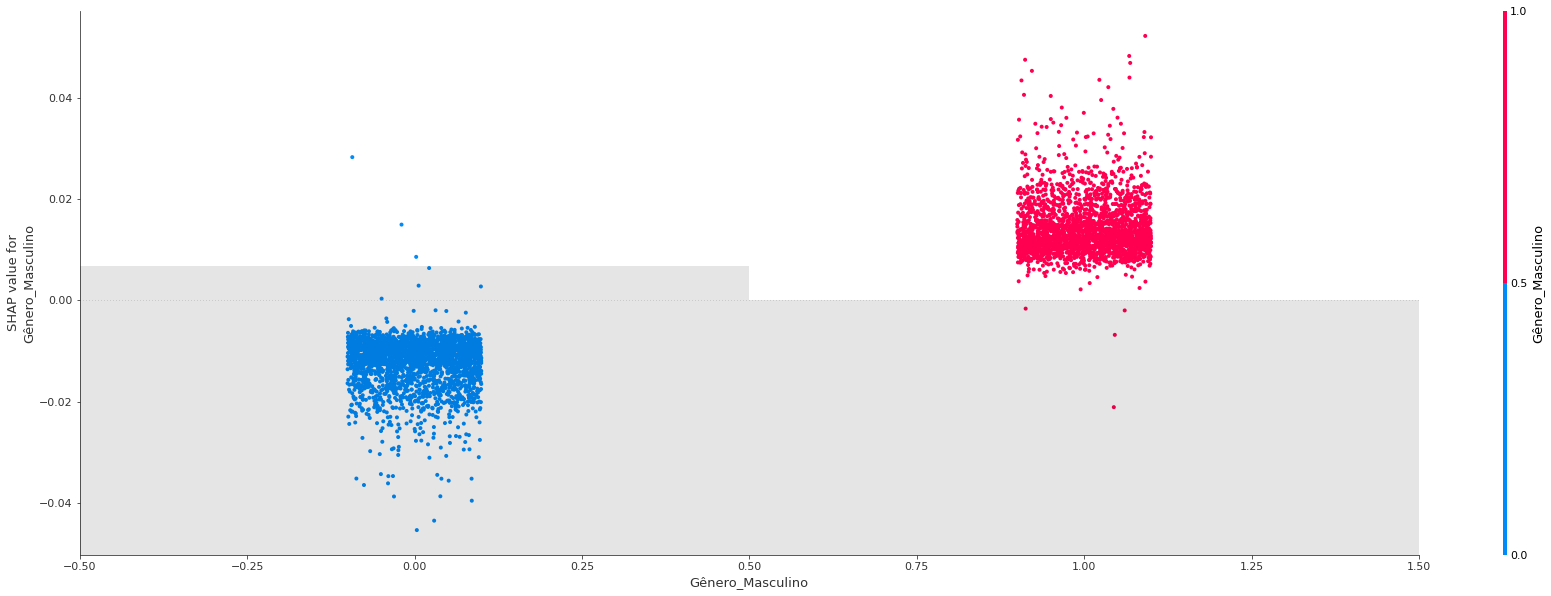

In [24]:
fig, ax = plt.subplots(1, figsize=(30,10))
shap.plots.scatter(shap_values[:,"Gênero_Masculino"], shap_values[:,"Gênero_Masculino"], ax=ax)

In [45]:
shap_data = pd.DataFrame({"shap_value":shap_values[:,"Gênero_Masculino"].values, "value":shap_values[:,"Gênero_Masculino"].data})
v_male = shap_data[shap_data["value"] == 1].shap_value.values
v_female = shap_data[shap_data["value"] == 0].shap_value.values

In [56]:
from scipy import stats
import numpy as np

In [151]:
s = np.random.normal(100, 3, 1000)
v = np.random.normal(100, 0, 1000)
stats.ttest_ind(s,100, axis=None, equal_var=False).pvalue

nan

In [52]:
v_male

array([ 0.01891465,  0.01275626,  0.01517177, ..., -0.00196272,
        0.01237441,  0.01230114], dtype=float32)

In [145]:
stats.ttest_ind(v_male,v_female, equal_var=False).pvalue

0.0

In [48]:
class ShapObject:
    
    def __init__(self, base_values, data, values, feature_names):
        self.base_values = base_values # Single value
        self.data = data # Raw feature values for 1 row of data
        self.values = values # SHAP values for the same row of data
        self.feature_names = feature_names # Column names

In [49]:
y_test["idx"] = np.arange(y_test.shape[0])
y_test.sort_values(by=list(y_test.columns), ascending=False)[:20]

,,,,,Total Motivo Interesse,idx
Identifica pessoa,Zona de domicílio,Data da entrevista,Coordenada X domicílio,Coordenada Y domicílio,,
00750498101,75.0,26092018,330913.0,7392548.0,5,15672
00250035101,25.0,19082017,331586.0,7394021.0,5,2449
02200010103,220.0,07042018,350538.0,7394838.0,4,13302
00920355101,92.0,29032018,329848.0,7397575.0,4,10915
03401003101,340.0,05062018,325603.0,7392933.0,4,8785
02680089101,268.0,22052018,328242.0,7386312.0,4,2642
00920331101,92.0,18112017,329831.0,7397603.0,3,15838
01340050101,134.0,24082017,333905.0,7401519.0,3,14987
01440006101,144.0,21112017,331609.0,7403283.0,3,14757


Total Motivo Interesse        5
idx                       15672
Name: (00750498101, 75.0, 26092018, 330913.0, 7392548.0), dtype: int64


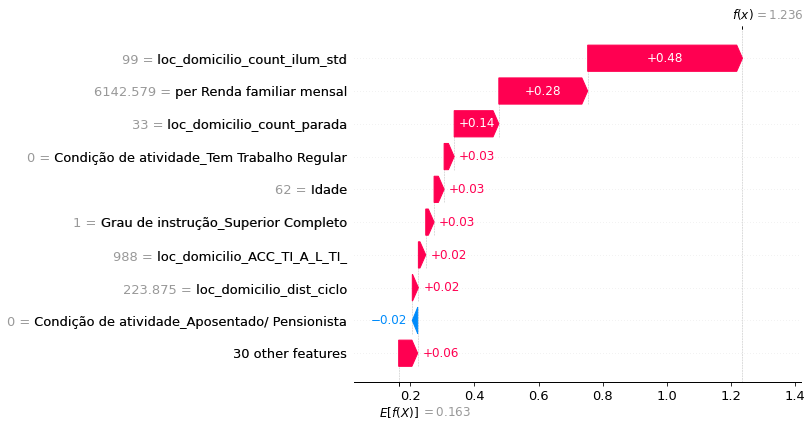

In [50]:
row = 15672
shap_object = ShapObject(base_values = shap_values[row].base_values[0],
                         values = shap_values[row].values,
                         feature_names = X_test.columns,
                         data = X_test.iloc[row])
print(y_test.iloc[row])
shap.waterfall_plot(shap_object)

Total Motivo Interesse        3
idx                       11888
Name: (00510491101, 51.0, 21082018, 334092.0, 7390592.0), dtype: int64


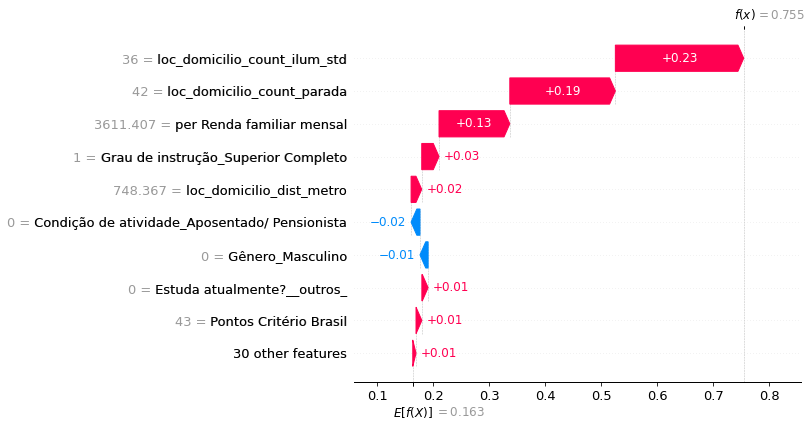

In [52]:
row = 11888
shap_object = ShapObject(base_values = shap_values[row].base_values[0],
                         values = shap_values[row].values,
                         feature_names = X_test.columns,
                         data = X_test.iloc[row])
print(y_test.iloc[row])
shap.waterfall_plot(shap_object)

Total Motivo Interesse     0
idx                       42
Name: (02030419102, 203.0, 16032018, 354669.0, 7396730.0), dtype: int64


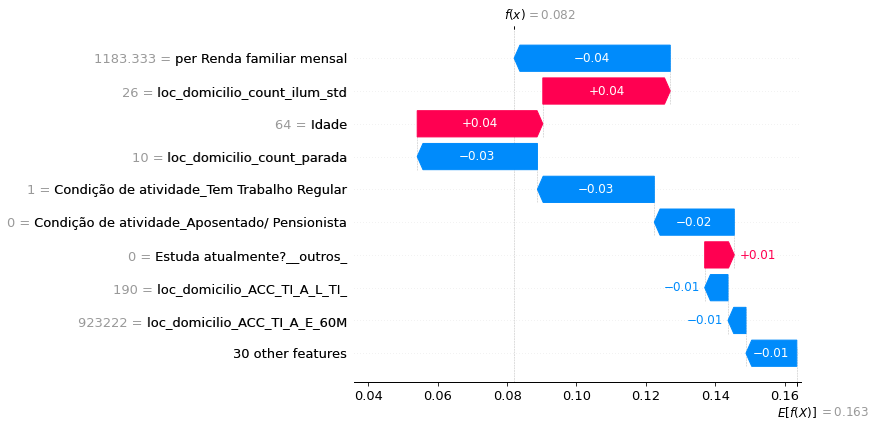

In [53]:
row = 42
shap_object = ShapObject(base_values = shap_values[row].base_values[0],
                         values = shap_values[row].values,
                         feature_names = X_test.columns,
                         data = X_test.iloc[row])
print(y_test.iloc[row])
shap.waterfall_plot(shap_object)